In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,  Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)




In [2]:
#téléchargement de la base de donnée
filepath = "./flute/"
#Liste de tous les fichiers midi 
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".midi"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)



In [3]:
#Fonction extraction des notes d'un dossier de plusieurs fichiers
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    #notes.append(".".join(str(n) for n in element.normalOrder))
                    notes.append(".".join(note.nameWithOctave for note in element.pitches))
                   
    print(notes)           
    return notes

#Création du corpus des notes de tous les fichier midi 
Corpus= extract_notes(all_midis)
print("Total des notes de trompettes dans la base de donnée", len(Corpus))

['E6.C#6', 'G5.F#5', 'D6.B5', 'F5.E5', 'C6.A5', 'E-5.D5', 'B-5.G#5', 'D5.C5', 'A5.F5', 'D5.B4', 'F5.D5', 'B4.G#4', 'B4.D5', 'F5.E5', 'D5.C5', 'B4.C5', 'E5.A5', 'C5.B4', 'A4.E4', 'G#5.A5', 'A4.G4', 'E4.F4', 'A5.E4', 'G5.D4', 'F5.E5', 'C#5.D5', 'B-5.C5', 'A5.G#5', 'E5.D5', 'B4.C5', 'E6.B4', 'D6.C5', 'C6.D5', 'B5.E5', 'A5.B5', 'G#5.A5', 'E4.A4', 'C5.E5', 'A4.C5', 'E5.A5', 'E5.A5', 'C6.E6', 'A5.C6', 'E6', 'A6', 'E5.A5', 'G#5.A5', 'C6.A5', 'E5.A4', 'E5.A5', 'G#5.A5', 'C6.A5', 'E5.A4', 'C5.E5', 'F5.G#4', 'F5.E5', 'D5.C5', 'E5.G#5', 'A5.E4', 'D5.C5', 'B4.A4', 'C5.E5', 'F5.G#4', 'F5.E5', 'D5.C5', 'E5.G#5', 'A5.E4', 'D5.C5', 'B4.A4', 'C5.G#4', 'A4.F4', 'D5.G#4', 'A4.E4', 'C5.G#4', 'A4.D4', 'C5.B4', 'A4.G#4', 'E4.G#4', 'B4.E5', 'G#5.B5', 'D6.F5', 'D6.B5', 'G#5.E5', 'D5.C5', 'B4.C5', 'A4.C5', 'E5.A5', 'C6.E6', 'F5.G5', 'B-5.G5', 'E5.C5', 'B-4.A4', 'G4.A4', 'F4.A4', 'C5.D5', 'F5.A5', 'C5.B4', 'G4.B4', 'D5.E5', 'G5.B5', 'D5.C5', 'A4.C5', 'E5.F5', 'A5.C6', 'E5.D5', 'B4.D5', 'F#5.G5', 'B5.D6', 'F5.E5

In [4]:
print(type(Corpus))
print("50 première note du corpus", Corpus[:50])

<class 'list'>
50 première note du corpus ['E6.C#6', 'G5.F#5', 'D6.B5', 'F5.E5', 'C6.A5', 'E-5.D5', 'B-5.G#5', 'D5.C5', 'A5.F5', 'D5.B4', 'F5.D5', 'B4.G#4', 'B4.D5', 'F5.E5', 'D5.C5', 'B4.C5', 'E5.A5', 'C5.B4', 'A4.E4', 'G#5.A5', 'A4.G4', 'E4.F4', 'A5.E4', 'G5.D4', 'F5.E5', 'C#5.D5', 'B-5.C5', 'A5.G#5', 'E5.D5', 'B4.C5', 'E6.B4', 'D6.C5', 'C6.D5', 'B5.E5', 'A5.B5', 'G#5.A5', 'E4.A4', 'C5.E5', 'A4.C5', 'E5.A5', 'E5.A5', 'C6.E6', 'A5.C6', 'E6', 'A6', 'E5.A5', 'G#5.A5', 'C6.A5', 'E5.A4', 'E5.A5']


In [5]:
def create_melody_stream(snippet):
    melody_stream = stream.Stream()
    offset = 0

    for chord_notes in snippet:
        # Si l'élément est un accord (représenté par une chaîne de caractères)
        if '.' in chord_notes:
            notes = []
            for note_str in chord_notes.split('.'):
                note_snip = note.Note(note_str)
                notes.append(note_snip)

            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            melody_stream.append(chord_snip)

        # Si l'élément est une note individuelle
        else:
            note_snip = note.Note(chord_notes)
            note_snip.offset = offset
            melody_stream.append(note_snip)

        offset += 1  # Ajustez ici le décalage entre chaque note ou accord

    return melody_stream


In [6]:
print(Corpus[:50])

['E6.C#6', 'G5.F#5', 'D6.B5', 'F5.E5', 'C6.A5', 'E-5.D5', 'B-5.G#5', 'D5.C5', 'A5.F5', 'D5.B4', 'F5.D5', 'B4.G#4', 'B4.D5', 'F5.E5', 'D5.C5', 'B4.C5', 'E5.A5', 'C5.B4', 'A4.E4', 'G#5.A5', 'A4.G4', 'E4.F4', 'A5.E4', 'G5.D4', 'F5.E5', 'C#5.D5', 'B-5.C5', 'A5.G#5', 'E5.D5', 'B4.C5', 'E6.B4', 'D6.C5', 'C6.D5', 'B5.E5', 'A5.B5', 'G#5.A5', 'E4.A4', 'C5.E5', 'A4.C5', 'E5.A5', 'E5.A5', 'C6.E6', 'A5.C6', 'E6', 'A6', 'E5.A5', 'G#5.A5', 'C6.A5', 'E5.A4', 'E5.A5']


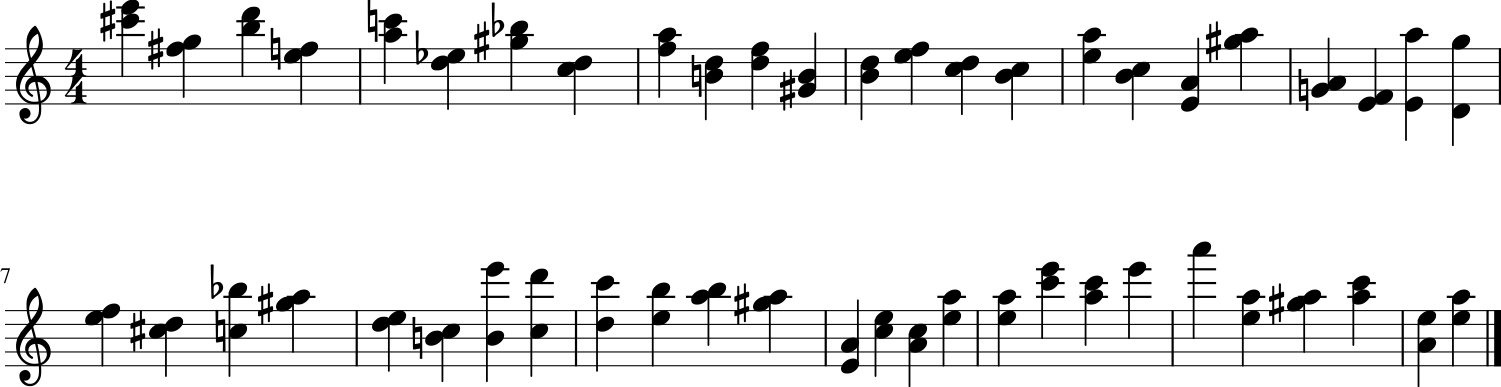

In [7]:
melody=create_melody_stream(Corpus[:50])
melody.show()


In [8]:
#Creation d'un disctionnaire de comptes
count_num = Counter(Corpus)
print("Total des notes différentes dans le coprus:", len(count_num))

Total des notes différentes dans le coprus: 224


In [9]:
#Exploration du disctionnaire
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
print(Recurrence)
#Les recurrences des notes
def Average(lst):
    return sum(lst) / len(lst)
print("Moyenne des récurrences des notes du corpus:", Average(Recurrence))
print("Frequence d'apparition de la note la plus présente:", max(Recurrence), "fois")
print("Frequence d'apparition de la note la moins présente:", min(Recurrence), "fois")

[1, 2, 2, 10, 4, 1, 1, 10, 1, 2, 3, 3, 2, 6, 7, 10, 3, 5, 6, 1, 3, 1, 4, 1, 1, 5, 1, 1, 1, 2, 5, 1, 3, 5, 2, 2, 9, 12, 2, 2, 3, 2, 3, 2, 3, 5, 3, 1, 3, 1, 1, 1, 1, 1, 3, 5, 3, 1, 1, 1, 3, 2, 1, 4, 6, 2, 2, 2, 1, 3, 2, 2, 4, 2, 2, 1, 5, 3, 2, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 2, 1, 1, 15, 24, 14, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 24, 11, 26, 8, 15, 19, 22, 12, 17, 11, 5, 32, 4, 29, 32, 11, 1, 26, 24, 13, 7, 10, 22, 12, 24, 21, 22, 5, 8, 1, 7, 5, 2, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Moyenne des récurrences des notes du corpus: 4.111607142857143
Frequence d'apparition de la note la plus présente: 32 fois
Frequence d'apparition de la note la moins présente: 1 fois


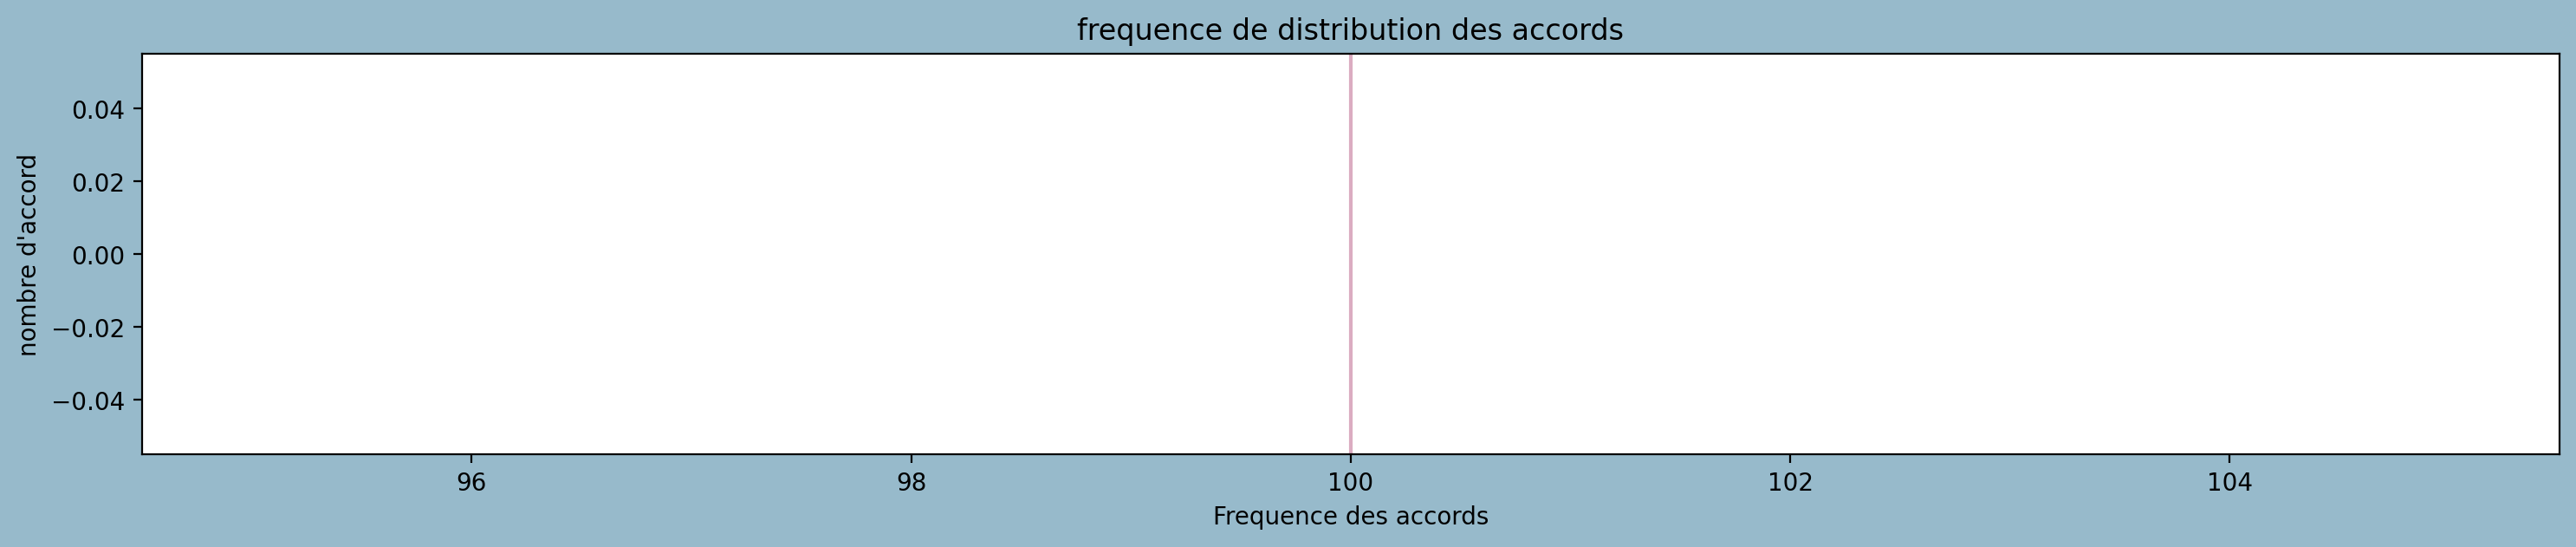

In [10]:
# affichage de la répartition des notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("frequence de distribution des accords")
plt.xlabel("Frequence des accords")
plt.ylabel("nombre d'accord")
plt.show()

In [11]:
#récupération des accords rares
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 150:
        m =  key
        rare_note.append(m)
        
print("nombres d'accord apparaissant moins de 5 fois:", len(rare_note))

nombres d'accord apparaissant moins de 5 fois: 224


In [12]:
#elimination des notes rares dans le corpus

for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("taille du corpus après élimination :", len(Corpus))

taille du corpus après élimination : 460


DATA PROCESSING


In [13]:


# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))



print("total de note du corpus:", L_corpus) #nombre total de caractères dans le texte.
print("nombre de note unique:", L_symb) #nombre total de caractères uniques présents dans le texte.

total de note du corpus: 460
nombre de note unique: 146


In [14]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("nombre total de sequence:", L_datapoints)

nombre total de sequence: 420


In [15]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL BUILDING

In [16]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [17]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 146)               37522     
                                                                 
Total params: 1,943,442
Trainable params: 1,943,442
Non-

In [18]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=5)

Epoch 1/5
2/2 [==============================] - 15s 2s/step - loss: 4.9743
Epoch 2/5
2/2 [==============================] - 5s 2s/step - loss: 6.9698
Epoch 3/5
2/2 [==============================] - 5s 2s/step - loss: 5.3239
Epoch 4/5
2/2 [==============================] - 7s 1s/step - loss: 4.7811
Epoch 5/5
2/2 [==============================] - 5s 2s/step - loss: 4.8067


EVALUATING MODELS

[Text(0.5, 0, 'Epochs')]

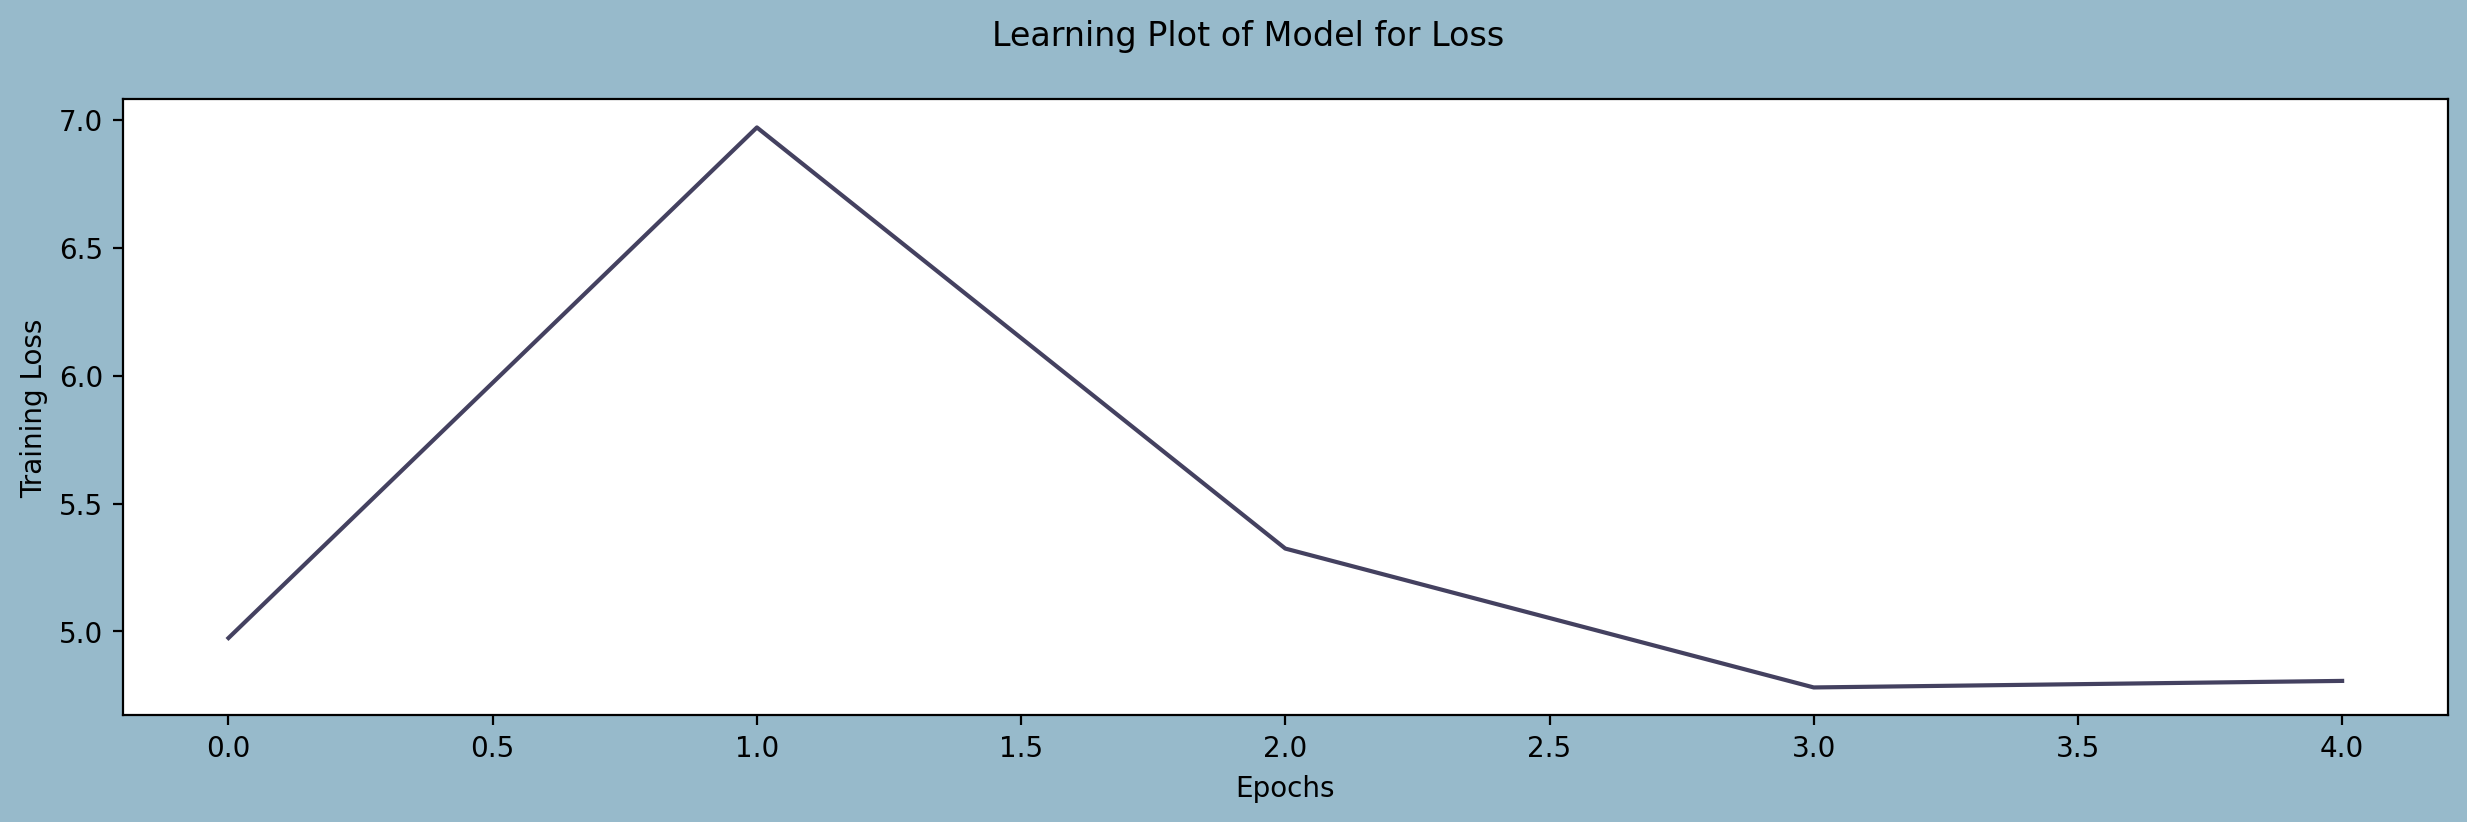

In [19]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [20]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0, len(X_seed) - 1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = create_melody_stream(Music)
    Melody_midi = stream.Stream(Melody)   
    return Melody,Melody_midi


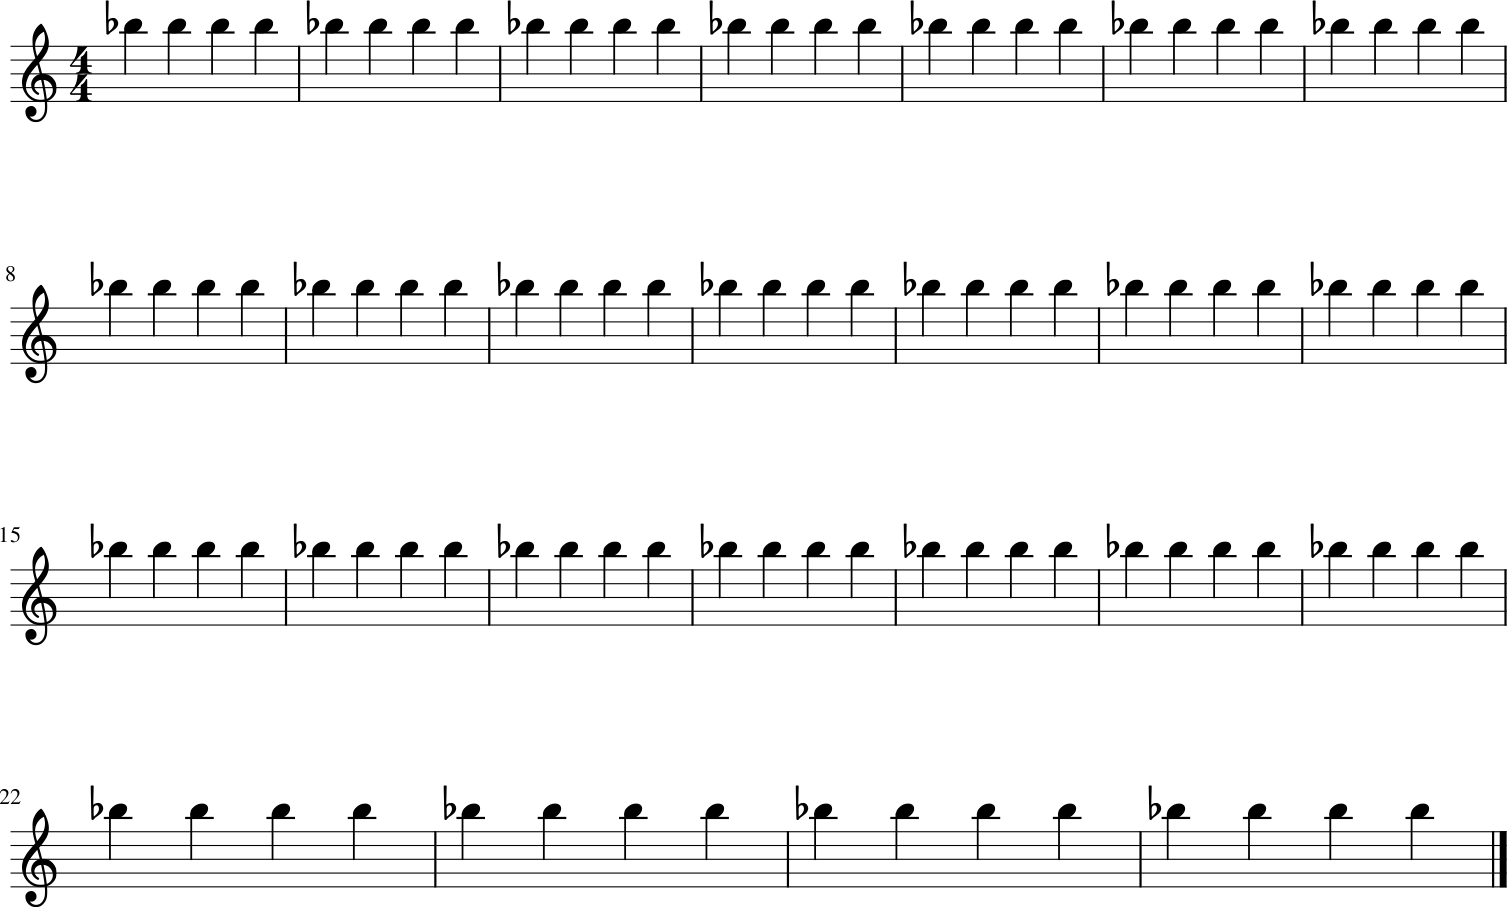

In [21]:
Melody,Melody_midi=Malody_Generator(100)
Melody.show()

In [22]:
# enregistrer le stream en midi 

Melody.write('midi', fp='./generer.mid')

'./generer.mid'